# Shapely

[Shapely user manual](http://toblerity.org/shapely/manual.html)

Shapely's the main library in Python for handling spatial geometries. It's used in [GeoPandas](http://geopandas.org/) to handle the geometries in GeoSeries/GeoDataFrames. The scope of the library is fairly limited, leaving data import and projections to other libraries ([fiona](http://toblerity.org/fiona/) and [pyproj](https://pypi.org/project/pyproj/) respectively).

In [1]:
%matplotlib inline

import shapely
import shapely.geometry as spg
import shapely.validation as spv

import shapely.wkt
import shapely.wkb


## Theoretical Backbone

The basic principle behind Shapely seems to be to pull an already available set of operators into Python, rather than having to go through PostGIS.

### Libraries Used

Shapely's used as the spatial data structure for Geopandas. It uses the [GEOS](http://trac.osgeo.org/geos/) library behind the scenes, same as PostGIS. As a result a lot of the names are shared - particularly the [DE-9IM](https://en.wikipedia.org/wiki/DE-9IM) language for spatial relations.

### Data Model

As Shapely uses GEOS as it's base, the geometry types are the fairly familiar ones:

* **Point** (````Point```` Class) - As the name suggests, just a point. There's nothing too unexpected here.
* **Curve** (````LineString```` / ````LinearRing ```` classes) - The name of lines in this structure. No smooth curves / circles here.
* **Surface** (````Polygon```` class) - The name of polygons in this structure.
* Collection objects follow the convention of appending 'multi' onto the front (````MultiPoint````, ````MultiLineString```` and ````MultiPolygon````). There is a generic mixed type ````GeometryCollection```` that can have any or no geometry types inside (though it's generally not a great idea to work with them).

The user manual defines them based on their interior, boundary and exterior:

 Geometry | Topological Dimension | Interior                        | Boundary    | Exterior          
----------|-----------------------|---------------------------------|-------------|-------------------
 Point    | 0                     | Exactly one point.              | None.       | All other points. 
 Curve    | 1                     | Any points along it's length.   | End points. | All other points.
 Surface  | 2                     | Any points within the boundary. | A curve.    | All other points.

### Coordinate Systems

Shapely **does not do coordinate system transformations** so using data with two crs will produce unexpected results. The 

The user manual does reference [pyproj](https://pypi.org/project/pyproj/) as a tool to help (is a port of PROJ4).

## Geometric Objects

The geometric objects defined in the standard Python way, with coordinates being passed in as tuples (with optional z values). Once defined, the coordinates are immutable with all numbers being converted to floats.

The simplicity / validity of shapes is not checked during creation, but can be checked with ````is_valid```` property on the result.

At present, the z-axis seems to be ignored in Shapely.

### Generic Object Methods & Attributes

Attribute / Method                    | Return Type | PostGIS Equivalent                                                   | Description   
--------------------------------------|-------------|----------------------------------------------------------------------|-------------  
````object.area````                   | float       | [ST_Area](http://postgis.org/docs/ST_Area.html)                      | The area of the object.
````object.bounds````                 | tuple float | [ST_Extent](http://postgis.org/docs/ST_Extent.html)                  | Tuple of ```` (minx, miny, maxx, maxy)````.
````object.length````                 | float       | [ST_Length](http://postgis.org/docs/ST_Length.html)                  | The length of the object.
````object.geom_type````              | string      | [ST_GeometryType](http://postgis.org/docs/ST_GeometryType.html)      | The name of the geometry type.
````object.distance(other)````        | float       | [ST_Distance](http://postgis.org/docs/ST_Distance.html)              | Distance to another object.
````object.representative_point()```` | Point       | [ST_PointOnSurface](http://postgis.org/docs/ST_PointOnSurface.html)  | A point guaranteed to be within the object.

### Geometry Creating Classes / Functions

 Called From             | Attribute / Method                           | Return Type     | Description   
-------------------------|----------------------------------------------|-----------------|------------------------------------------  
````shapely.geometry```` | ````Point(coordinates)````                   | Point           | Makes a Point with the given coordinates. 
````shapely.geometry```` | ````LineString(coordinates)````              | LineString      | Makes a LineString with the given coordinates. 
````shapely.geometry```` | ````LinearRing(coordinates)````              | LinearRing      | Makes a LinearRing with the given coordinates. 
````shapely.geometry```` | ````Polygon(exterior[, interiors=None])````  | Polygon         | Makes a Polygon with the given coordinates. 
````shapely.geometry```` | ````box(minx, miny, maxx, maxy, ccw=True)````| Polygon         | Makes a Polygon with the given extent. 
````shapely.geometry```` | ````MultiPoint(points)````                   | MultiPoint      | 
````shapely.geometry```` | ````MultiLineString(lines)````               | MultiLineString | 
````shapely.geometry```` | ````MultiPolygon(polygons)````               | MultiPolygon    | 


### Points

Points are generated from the ````Point```` class, which only needs to take an X and Y coordinate.

POINT (0 1)


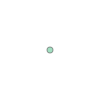

In [2]:
the_point = spg.Point(0.0, 1.0)
print(the_point)
the_point

Points have 0 length and area, and a bounding box with 0 area:

In [3]:
print(the_point.area)
print(the_point.length)
print(the_point.bounds)

0.0
0.0
(0.0, 1.0, 0.0, 1.0)


Passing a point to the ````Point```` constructor will copy that point:

In [4]:
print(spg.Point(the_point))

POINT (0 1)


### LineStrings

Linestrings are the standard line geometry. They can have repeated points, but it's not advised (unnecessary performance hits etc).

Linestrings can be constructed with the ````LineString```` constructor (though cannot be created with a series of ````Point```` objects):

LINESTRING (0 0, 1 1)


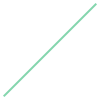

In [5]:
the_line = spg.LineString([(0, 0), (1, 1)])
print(the_line)
the_line

Like points, lines have 0 area, but do have length:

In [6]:
print(the_line.area)
print(the_line.length)
print(the_line.bounds)

0.0
1.4142135623730951
(0.0, 0.0, 1.0, 1.0)


They can also be copied by passing the line in to another object:

In [7]:
print(spg.LineString(the_line))

LINESTRING (0 0, 1 1)


### LinearRings

LinearRings are LineStrings, but must close themselves. If the sewries of coordinates provided doesn't close on its own then they will copy the first point to the end.

LinearRings are invalid if it crosses itself or touches itself at a single point (though this won't cause an error, it throws an error with processing algorithms).

Otherwise LinearRings are identical to LineStrings.

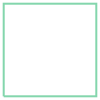

In [8]:
the_ring = spg.LinearRing([(0, 0), (1, 0), (1, 1), (0, 1)])
the_ring

### Polygon

Polygons are constructed in a similar way to LinearRings, but can also take a second set of sequences that can be turned into rings. They can also be constructed from ````LineStrings```` or ````LinearRings```` directly.

As with other objects, invalid polygons can be constructed, but not operated on. A valid polygon may not have rings that cross, but rings can touch at a single point only.

As in PostGIS, the winding direction (called orientation here) is counterclockwise for the exterior ring and clockwise on the interior ones. This can be forced for the exterior ring with ````polygon.orient````.

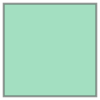

In [9]:
the_polygon = spg.Polygon([(-1, -1), (2, -1), (2, 2), (-1, 2)])
the_polygon

Polygons have both length and area (assuming it's valid):

In [10]:
print(the_polygon.area)
print(the_polygon.length)
print(the_polygon.bounds)

9.0
12.0
(-1.0, -1.0, 2.0, 2.0)


And an example of more complex definition:

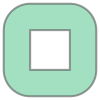

In [11]:
#the_polygon_rings = spg.Polygon(the_polygon.buffer(2), the_polygon)
the_polygon_rings = spg.Polygon(the_polygon.buffer(2).exterior,
                                [the_polygon.exterior]
                               )
the_polygon_rings

A more convenient way to generate a polygon is with ```box```

Attribute / Method            | Return Type | PostGIS Equivalent | Description   
------------------------------|-------------|--------------------|-------------  
````shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)````                   | Polygon     | [ST_Envelope](https://postgis.net/docs/ST_Envelope.html)            | A square polygon.

### Accessing Coordinates

Coordinates can be accessed by the ````coords````, ````x````, ````y```` and ````z```` properties or by slicing the output of ````coords````:

In [12]:
print(the_point.coords)
print(list(the_point.coords))
print(the_point.x)
print(the_point.y)
print(the_point.coords[:])

[(0.0, 1.0)]
0.0
1.0
[(0.0, 1.0)]


Though the slicing is more useful for lines than points:

In [13]:
print(the_line.coords[:])
print(the_line.coords[1:])

[(0.0, 0.0), (1.0, 1.0)]
[(1.0, 1.0)]


For polygons, you have to go through the extra layer of ````exterior```` or ````interiors```` with ````interiors```` being a list of rings, so needs subsetting first.

In [14]:
print(list(the_polygon.exterior.coords))
print(list(the_polygon_rings.interiors[0].coords))

[(-1.0, -1.0), (2.0, -1.0), (2.0, 2.0), (-1.0, 2.0), (-1.0, -1.0)]
[(-1.0, -1.0), (2.0, -1.0), (2.0, 2.0), (-1.0, 2.0), (-1.0, -1.0)]


## Geometry Properties (Unary Predicates)

These are attributes that can be called on any geometry object, returning ````True```` or ````False```` only. They seem to be precalculated attributes rather than methods calculated as needed.

Name            | Manual Link                                                       | Used on                            | Description                                                                                   
-------------|-------------------------------------------------------------------|------------------------------------|-----------------------------------------------------------------------------------------------
 .has_z      | [Link](http://toblerity.org/shapely/manual.html#object.has_z)     | All                                | If the feature has z values (is 3D).                                                          
 .is_ccw     | [Link](http://toblerity.org/shapely/manual.html#object.is_ccw)    | All                                | If the geometry is wound counter-clockwise (will give an internal area that's positive).                                                   
 .is_empty   | [Link](http://toblerity.org/shapely/manual.html#object.is_empty)  | All                                | If the features *interior* and *boundary* coincide with an empty set.                         
 .is_ring    | [Link](http://toblerity.org/shapely/manual.html#object.is_ring)   | LineString, LinearRing             | If the feature is closed.                                                                     
 .is_simple  | [Link](http://toblerity.org/shapely/manual.html#object.is_simple) | LineString, LinearRing             | If the feature does not cross itself. Operations on non-simple linestrings aren't suppoprted. 
 .is_valid   | [Link](http://toblerity.org/shapely/manual.html#object.is_valid)  | LinearRing, Polygon , MultiPolygon | If the feature is valid.                                                                      

Rather than requiring a valid geometry at the time of construction (which would also hamstring data imports from most sources I've seen), the valid geometry is required when it's operated on. 


## Geometric Relationships (Binary Predicates)

These all take an ````other```` argument that's another geometry, with some having additional arguments. The plain-language descriptions are the [standard ones](https://en.wikipedia.org/wiki/DE-9IM#Spatial_predicates), but I've included the full desciptions for clarity.

 Name           | Additional arguments | Manual Link                                                           | Description                                                                                                                                                                           
----------------|----------------------|-----------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 .almost_equals | decimal=6            | [Link](http://toblerity.org/shapely/manual.html#object.almost_equals) | If the object is approximately equal to the ````other```` at all points.                                                                                                              
 .contains      |                      | [Link](http://toblerity.org/shapely/manual.html#object.contains)      | If the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all. This is the inverse of ````within````.                      
 .crosses       |                      | [Link](http://toblerity.org/shapely/manual.html#object.crosses)       | If the interior of the object intersects the interior of the other but does not contain it, and the dimension of the intersection is less than the dimension of the one or the other. 
 .disjoint      |                      | [Link](http://toblerity.org/shapely/manual.html#object.disjoint)      | If the boundary and interior of the object do not intersect at all with those of the other. Inverse of intersects.                                                                    
 .equals        |                      | [Link](http://toblerity.org/shapely/manual.html#object.equals)        | If the boundary, interior, and exterior are all the same. Note it operates independently of ````=```` or ````is````.                                                                  
 .intersects    |                      | [Link](http://toblerity.org/shapely/manual.html#object.intersects)    | If the boundary and interior of the object intersect in any way with those of the other. The most lenient relationship to be fulfilled.                                               
 .touches       |                      | [Link](http://toblerity.org/shapely/manual.html#object.touches)       | If the objects have at least one point in common and their interiors do not intersect with any part of the other. Quite different to Intersects.                                      
 .within        |                      | [Link](http://toblerity.org/shapely/manual.html#object.within)        | If the object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior).                                                                   

One useful feature of these is that they can be used as predicates for ````filter```` calls.

Also there's the ````relate```` method that returns the DE-9IM matrix of the two objects:

 Name           | Additional arguments | Manual Link                                                           | Description                                                                                                                                                                           
----------------|----------------------|-----------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 .relate        |                      | [Link](http://toblerity.org/shapely/manual.html#object.relate)        | Returns a string representation of the DE-9IM matrix of relationships between an object’s interior, boundary, exterior and those of another geometric object.

The manual also highlights the option to use ````within```` to create a sorting function to spatially sort a set of geometries:

In [15]:
class Within(object):
    def __init__(self, o):
        self.o = o
    def __lt__(self, other):
        return self.o.within(other.o)

a = spg.Point(2, 2)
b = spg.Polygon([[1, 1], [1, 3], [3, 3], [3, 1]])
c = spg.Polygon([[0, 0], [0, 4], [4, 4], [4, 0]])
d = spg.Point(-1, -1)

features = [c, a, d, b, c]
features_s = sorted(features, key=Within, reverse=True)

[print(x) for x in features]
print('\n')
[print(x) for x in features_s]
print("")

POLYGON ((0 0, 0 4, 4 4, 4 0, 0 0))
POINT (2 2)
POINT (-1 -1)
POLYGON ((1 1, 1 3, 3 3, 3 1, 1 1))
POLYGON ((0 0, 0 4, 4 4, 4 0, 0 0))


POINT (-1 -1)
POLYGON ((0 0, 0 4, 4 4, 4 0, 0 0))
POLYGON ((0 0, 0 4, 4 4, 4 0, 0 0))
POLYGON ((1 1, 1 3, 3 3, 3 1, 1 1))
POINT (2 2)



## Geometry Generation / Derivation

These are methods called on a geometry that return another geometry

 Name                                                                                   | Manual.Link                                                                  | PostGIS.Equivalent                                                                                                                                 | Description                                                                                                                                                                                                      
----------------------------------------------------------------------------------------|------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 ````.boundary````                                                                      | [Link](http://toblerity.org/shapely/manual.html#object.boundary)             | [ST_Boundary](https://postgis.net/docs/ST_Boundary.html)                                                                                           | Returns a lower dimensional object representing the object’s set-theoretic boundary.                                                                                                                             
 ````.centroid````                                                                      | [Link](http://toblerity.org/shapely/manual.html#object.centroid)             | [ST_Centroid](https://postgis.net/docs/ST_Centroid.html)                                                                                           | Returns a representation of the object’s geometric centroid (point).                                                                                                                                             
 ````.difference(other)````                                                             | [Link](http://toblerity.org/shapely/manual.html#object.difference)           | [ST_Difference](https://postgis.net/docs/ST_Difference.html)                                                                                       | Returns a representation of the points making up this geometric object that do not make up the other object.                                                                                                     
 ````.intersection(other)````                                                           | [Link](http://toblerity.org/shapely/manual.html#object.intersection)         | [ST_Intersection](https://postgis.net/docs/ST_Intersection.html)                                                                                   | Returns a representation of the intersection of this object with the other geometric object.                                                                                                                     
 ````.symmetric_difference(other)````                                                   | [Link](http://toblerity.org/shapely/manual.html#object.symmetric_difference) | [ST_SymDifference](https://postgis.net/docs/ST_SymDifference.html)                                                                                 | Returns a representation of the points in this object not in the other geometric object, and the points in the other not in this geometric object. Basically the union of the difference run in both directions. 
 ````.union(other)````                                                                  | [Link](http://toblerity.org/shapely/manual.html#object.union)                | [ST_Union](https://postgis.net/docs/ST_Union.html)                                                                                                 | Returns a representation of the union of points from this object and the other geometric object.                                                                                                                 
 ````.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=1.0)````   | [Link](http://toblerity.org/shapely/manual.html#object.buffer)               | [ST_Buffer](https://postgis.net/docs/ST_Buffer.html)                                                                                               | Returns an approximate representation of all points within a given distance of the this geometric object (see notes).                                                                                            
 ````.convex_hull````                                                                   | [Link](http://toblerity.org/shapely/manual.html#object.convex_hull)          | [ST_ConvexHull](https://postgis.net/docs/ST_ConvexHull.html)                                                                                       | Returns the convex hull of a geometry.                                                                                                                                                                           
 ````.envelope````                                                                      | [Link](http://toblerity.org/shapely/manual.html#object.envelope)             | [ST_Envelope](https://postgis.net/docs/ST_Envelope.html)                                                                                           | Returns a representation of the point or smallest rectangular polygon (with sides parallel to the coordinate axes) that contains the object.                                                                     
 ````.parallel_offset(distance, side, resolution=16, join_style=1, mitre_limit=1.0)```` | [Link](http://toblerity.org/shapely/manual.html#object.parallel_offset)      | [ST_OffsetCurve](https://postgis.net/docs/ST_OffsetCurve.html)                                                                                     | Returns a LineString or MultiLineString geometry at a distance from the object on its right or its left side (see notes). Only available for LinearRing and LineString.                                          
 ````.simplify(tolerance, preserve_topology=True)````                                   | [Link](http://toblerity.org/shapely/manual.html#object.simplify)             | [ST_Simplify](https://postgis.net/docs/ST_Simplify.html), [ST_SimplifyPreserveTopology](https://postgis.net/docs/ST_SimplifyPreserveTopology.html) | Returns a simplified geometry (Douglas-Peucker or topology-preserving equivalent).                                                                                                                               

### Buffers / Parallel Offset Parameters

The buffer and parallel offset operations have enough options to need their own section here (they share most of the same parameters).

Cap & join styles are stored as integers, also accessible via attributes for [cap styles](http://toblerity.org/shapely/manual.html#shapely.geometry.CAP_STYLE):

 Attribute                                 | Value | Description                                                      
-------------------------------------------|-------|------------------------------------------------------------------
 ````shapely.geometry.CAP_STYLE.round````  | 1     | The line end is expanded to approximate a portion of a circle.   
 ````shapely.geometry.CAP_STYLE.flat````   | 2     | The line is extended to both sides, but not beyond the line-end. 
 ````shapely.geometry.CAP_STYLE.square```` | 3     | The line end is expanded to approximate a square.                

And for [join stypes](http://toblerity.org/shapely/manual.html#shapely.geometry.JOIN_STYLE):

Attribute                                 | Value | Description                                                                                                                                   
------------------------------------------|-------|-----------------------------------------------------------------------------------------------------------------------------------------------
````shapely.geometry.JOIN_STYLE.round```` | 1     | Each corner is expanded to approximate a portion of a circle.                                                                                 
````shapely.geometry.JOIN_STYLE.mitre```` | 2     | The buffered edges are extended until they join (up until the ````mitre_limit````). ([Mitre Join](https://en.wikipedia.org/wiki/Miter_joint)) 
````shapely.geometry.JOIN_STYLE.bevel```` | 3     | The buffered edges are extended with the end flattened off ([Bevel](https://en.wikipedia.org/wiki/Bevel))                                     

With round caps / joins being estimated using a number of points specified by the ````resolution```` argument. By default both styles are rounded.

The ````mitre_limit```` is a measure of how far out the mitred point will be before it's bevelled off.

A buffer of radius 0 *is* calculated, so will re-generate the geometry & clean up self-touching/self-crossing polygons.

## Affine Transformations

Shapely supports affine transformations through the ````shapely.affinity```` module. This canbe done either through single-process functions or as a matrix-based transformation.

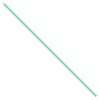

In [16]:
shapely.affinity.rotate(the_line, 90)

 Name                                                                                    | Description                                                                                             
-----------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------
 ````shapely.affinity.affine_transform(geom, matrix)````                                 | Returns a transformed geometry using an affine transformation matrix.                                   
 ````shapely.affinity.rotate(geom, angle, origin='center', use_radians=False)````        | Returns a rotated geometry on a 2D plane.                                                               
 ````shapely.affinity.scale(geom, xfact=1.0, yfact=1.0, zfact=1.0, origin='center')````  | Returns a scaled geometry, scaled by factors along each dimension. Negative factors mirror coordinates. 
 ````shapely.affinity.skew(geom, xs=0.0, ys=0.0, origin='center', use_radians=False)```` | Returns a skewed geometry, sheared by angles along x and y dimensions.                                  
 ````shapely.affinity.translate(geom, xoff=0.0, yoff=0.0, zoff=0.0)````                  | Returns a translated geometry shifted by offsets along each dimension.                                  



The transformation matrix is provided as a list / tuple with 6 (for 2D) or 12 (for 3D) transformations, e.g. ````[a, b, d, e, xoff, yoff]````.

Origin can be ````'center'```` (bbox centre),  ````'centroid'```` (geometry centroid), a point or a coordinate tuple ````(x0, y0)````.

## Validating Geometries

As mentioned above - Shapely will let invalid geometries be defined, but won't do any sort of checking on the inputs. The ````.is_valid```` method is useful, but doesn't actually solve anything.

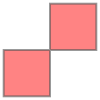

In [17]:
fig_of_eight = spg.Polygon([(-1, -1), (0, -1), (0, 1),
                            (1, 1), (1, 0), (-1, 0)
                           ])
fig_of_eight

In [18]:
print(fig_of_eight.area)
print(fig_of_eight.is_valid)

0.0
False


The ````explain_validity```` function in the ````validation```` module will explain the problem (seems to be the only real function in the module at the time of writing).

In [19]:
print(spv.explain_validity(fig_of_eight))

Self-intersection[0 0]


While the manual states ````.buffer(0)```` will fix self-crossing polygons, this doesn't seem to actually be the case:

1.0
(0.0, 0.0, 1.0, 1.0)


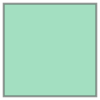

In [20]:
print(fig_of_eight.buffer(0).area)
print(fig_of_eight.buffer(0).bounds)
fig_of_eight.buffer(0)

As shown above - it cuts off the lower half of the geometry - so not something to trust 100% blind. Some functions *don't* seem to care however. There doesn't seem to be a comprehensive way to validate geometries so it seems to be a case of never assuming data quality.

It's probably not the worst idea to define a function to attempt the clean - and return the original if the bounds change.

## External Formats

Shapely's also capable of importing from / exporting to a number of other formats, the list of methods / attributes is:

 Name              | Output.Format                                                                        | Description                                              
-------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------
 ````.to_wkt()```` | [Well-Known Text](https://en.wikipedia.org/wiki/Well-known_text)                     | The WKT representation to 14 decimal places (fixed).     
 ````.to_wkb()```` | [Well-known Binary](https://en.wikipedia.org/wiki/Well-known_text#Well-known_binary) | The WKB of the geometry as a ````bytes```` object.       
 ````.svg()````    | [Scalable Vector Graphics](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics)   | The SVG representation of the geometry (pre-set styles). 
 ````.wkb````     | [Well-known Binary](https://en.wikipedia.org/wiki/Well-known_text#Well-known_binary) | The WKB of the geometry as a ````bytes```` object.       
 ````.wkb_hex`````  | [Well-known Binary](https://en.wikipedia.org/wiki/Well-known_text#Well-known_binary) | The WKB of the geometry as a hex string.                 
 ````.wkt````      | [Well-known Text](https://en.wikipedia.org/wiki/Well-known_text)                     | The WKT representation with trailing 0's trimmed.        


The ````wkt```` & ````wkb```` modules are [also ways of importing / exporting data](http://toblerity.org/shapely/manual.html#well-known-formats). The ````loads```` and ````dumps```` functions take an object as input, whereas ````load```` and ````dump```` go direct from a file. The source / destination depends on the module being used:

In [21]:
print(list(shapely.wkt.loads('POINT(5.001 42)').coords))
print(shapely.wkt.dumps(the_point))
print(shapely.wkb.dumps(the_point))

[(5.001, 42.0)]
POINT (0.0000000000000000 1.0000000000000000)
b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?'


There's also provision to adapt any other type of object to a Shapely geometry by using the [geointerface](https://gist.github.com/sgillies/2217756).

I've not read through it thoroughly, but it seems to be based on defining a ````__geo_interface__```` method for the class - just a dictionary with a set of standard properties. This is more for developers - but seems to be a standard shared by several libraries.

In [22]:
print(the_point.__geo_interface__)
print(the_line.__geo_interface__)
print(the_ring.__geo_interface__)
print(the_polygon.__geo_interface__)
# print(the_polygon_rings.__geo_interface__)

{'type': 'Point', 'coordinates': (0.0, 1.0)}
{'type': 'LineString', 'coordinates': ((0.0, 0.0), (1.0, 1.0))}
{'type': 'LinearRing', 'coordinates': ((0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0), (0.0, 0.0))}
{'type': 'Polygon', 'coordinates': (((-1.0, -1.0), (2.0, -1.0), (2.0, 2.0), (-1.0, 2.0), (-1.0, -1.0)),)}
